In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import (
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
)

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3)

uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

In [3]:
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "policy 1",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "0_RfR 1": 1, "0_RfR 2": 1, "A.1_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "policy 2",
        **dict(
            get_do_nothing_dict(),
            **{"4_RfR 0": 1, "4_RfR 1": 1, "4_RfR 2": 1, "A.5_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "policy 3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "2_RfR 1": 1, "3_RfR 2": 1, "A.3_DikeIncrease 0": 5}
        )
    ),
]

In [5]:
# pass the policies list to EMA workbench experiment runs #`1`
n_scenarios = 50
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

experiments, outcomes = results

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 50 scenarios * 3 policies * 1 model(s) = 150 experiments
100%|████████████████████████████████████████| 150/150 [00:06<00:00, 23.20it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 150 points remaining, containing 61 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.2, coverage: 0.4918032786885246, density: 1.0 restricted_dimensions: 5


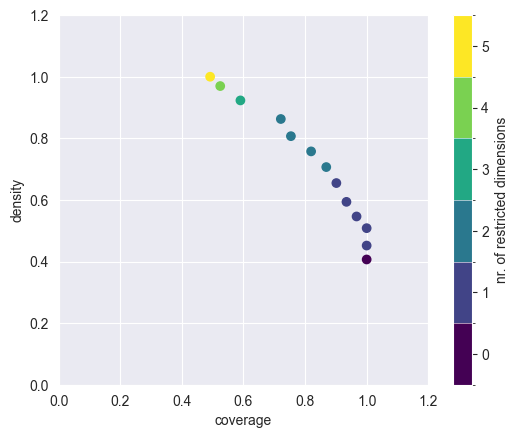

In [6]:
from ema_workbench.analysis import prim

df = pd.DataFrame(outcomes)
df_exp = pd.DataFrame(experiments)
x = df_exp
y= df['A.2 Total Costs']
y= y < 26042749

prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha= 0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()